In [4]:
import os
import cv2
import wandb
import pickle
import numpy as np
from tqdm import tqdm
from PIL import Image

In [5]:
import torch
from torch.utils.data import random_split, Dataset, DataLoader

In [6]:
pre_seq_length = 11 # x-frames
aft_seq_length = 11 # y-frames (to predict)

In [7]:
def extract_num(s):
    return int(s.split('_')[1])

def extract_image_num(s):
    return int(s.split('_')[1].split('.')[0])

In [8]:
class ClevrerDataSet(Dataset):
    def __init__(self, root, is_train=True, n_frames_input=11, n_frames_output=11, transform=None):
        super(ClevrerDataSet, self).__init__()

        self.videos = []
        unlabelled_dirs = os.listdir(root)
        unlabelled_dirs = sorted(unlabelled_dirs, key=extract_num)

        for video in unlabelled_dirs:
            self.videos.extend([root + '/' + video + '/'])
        
        self.length = len(self.videos)

        self.is_train = is_train

        self.n_frames_input = n_frames_input
        self.n_frames_output = n_frames_output
        self.n_frames_total = self.n_frames_input + self.n_frames_output
        self.transform = transform
        # For generating data
        self.mean = 0
        self.std = 1

    def __getitem__(self, index):
        length = self.n_frames_input + self.n_frames_output
        # print(self.videos[index])
        video_folder = os.listdir(self.videos[index])
        
        # Remove mask file (for train videos)
        if "mask.npy" in video_folder:
            video_folder.remove("mask.npy")
    
        video_folder = sorted(video_folder, key=extract_image_num)
        imgs = []
        for image in video_folder:
            imgs.append(np.array(Image.open(self.videos[index] + '/' + image)))

        #shape: torch.Size([10, 1, 64, 64])
        # print(len(imgs))

        past_clips = imgs[0:self.n_frames_input] #[11,160,240,3]
        future_clips = imgs[-self.n_frames_output:] #[11,160,240,3]

        past_clips = [torch.from_numpy(clip) for clip in past_clips]
        future_clips = [torch.from_numpy(clip) for clip in future_clips]
        # stack the tensors and permute the dimensions

        past_clips = torch.stack(past_clips).permute(0, 3, 1, 2)
        future_clips = torch.stack(future_clips).permute(0, 3, 1, 2)
        #we want [11,3,160,240]
        return (past_clips).contiguous().float(), (future_clips).contiguous().float()
    
    def __len__(self):
        return self.length

In [9]:
def load_clevrer(batch_size, val_batch_size, data_root, num_workers):

    whole_data = ClevrerDataSet(root=data_root, is_train=True, n_frames_input=11, n_frames_output=11)

    train_size = int(0.9 * len(whole_data))
    val_size = int(0.09 * len(whole_data))
    test_size = len(whole_data) - (train_size+val_size)
    print(train_size, val_size, test_size)
    train_data, val_data, test_data = random_split(whole_data, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(2023))

    train_loader = DataLoader(train_data.dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_data.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_data.dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    mean, std = 0, 1
    return train_loader, val_loader, test_loader, mean, std

In [10]:
batch_size = 8

In [11]:
dataloader_train, dataloader_val, dataloader_test, mean, std = load_clevrer(batch_size=batch_size, 
                                                                            val_batch_size=batch_size, 
                                                                            data_root="../dataset/val/",
                                                                            num_workers=1)

900 90 10


In [12]:
dataloader_val

### 2.2 Get the dataloaders

Now we can get the dataloaders by using the collected dataset and the defined `CustomDataset`.

#### hyperparameters

`batch_size`: the size of a batch

In [13]:
# batch_size = 1

In [14]:
# X_train, X_val, Y_train, Y_val = dataset['X_train'], dataset['X_val'], dataset['Y_train'], dataset['Y_val']

# train_set = CustomDataset(X=X_train, Y=Y_train)
# val_set = CustomDataset(X=X_val, Y=Y_val)

In [15]:
# dataloader_train = torch.utils.data.DataLoader(
#     train_set, batch_size=batch_size, shuffle=True, pin_memory=True)
# dataloader_val = torch.utils.data.DataLoader(
#     val_set, batch_size=batch_size, shuffle=True, pin_memory=True)

In [16]:
# next(iter(dataloader_train))

## 3. Train and evaluate

### 3.1 Define the custom configs

We first define the training configuration, which includes several important hyperparameters for training.

Here, we set `epoch = 3` as an example for simple training. The actual value of epoch in your project depends on the complexity of your dataset. Generally, a good starting point is `epoch = 100`.

Next, we define the model configuration to customize a spatio-temporal predictive learning model. For MetaVP models, the key hyperparameters are: `N_S`, `N_T`, `hid_S`, `hid_T`, and `model_type`. Users have the option to either use a config file or directly set these hyperparameters.

If a config file is preferred, the user can simply include a `config_file` key with the path to the config file in the `custom_model_config` below. Otherwise, the user can directly specify these hyperparameters in the `custom_model_config`.

In [17]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 3,
    'lr': 0.001,
    'metrics': ['mse', 'mae'],

    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [11, 3, 160, 240], # (T,C,H,W)
}

### SimVP

In [18]:
# ---------- https://github.com/chengtan9907/OpenSTL/tree/master/configs
custom_model_config = {
    # For MetaVP models, the most important hyperparameters are:
    # N_S, N_T, hid_S, hid_T, model_type
    'method': 'SimVP',
    # Users can either using a config file or directly set these hyperparameters
    # 'config_file': 'configs/custom/example_model.py',

    # Here, we directly set these parameters
    'model_type': 'gSTA',
    'N_S': 4,
    'N_T': 8,
    'hid_S': 64,
    'hid_T': 256,


    "sched": "onecycle" # <Adding to prevent code fail> -- onecycle, cosine, tanh, step, multistep
}

### DMVFN

In [21]:
custom_training_config = {
    'pre_seq_length': pre_seq_length,
    'aft_seq_length': aft_seq_length,
    'total_length': pre_seq_length + aft_seq_length,
    #'batch_size': batch_size,
    'val_batch_size': batch_size,
    'epoch': 3,
    #'lr': 0.001,
    'metrics': ['mse', 'mae'],
    'ex_name': 'custom_exp',
    'dataname': 'custom',
    'in_shape': [11, 3, 160, 240], # (T,C,H,W)
}

# ---------- https://github.com/chengtan9907/OpenSTL/tree/master/configs
custom_model_config = {
    'method': 'DMVFN',
    'config_file': 'configs/kth/DMVFN.py',
     "routing_out_channels": 32,
      "in_planes": 4 * 1 + 1 + 4, # the first 1: data channel, the second 1: mask channel, the third 4: flow channel
      "num_block": 9,
      "num_features": [160, 160, 160, 80, 80, 80, 44, 44, 44],
      "scale": [4, 4, 4, 2, 2, 2, 1, 1, 1],
      "training": True,
      "beta": 0.5,
      "gamma": 0.8,
      "coef": 0.5,
      # training,
      "lr": 5e-5,
      "batch_size": 16,
      "sched": 'onecycle'
}

### TAU

In [22]:
custom_model_config = {"method": 'TAU',
                       "config_file": 'x',
                    # model
                    "spatio_kernel_enc": 3,
                    "spatio_kernel_dec": 3,
                    "model_type": 'tau',
                    "hid_S": 64,
                    "hid_T": 512,
                    "N_T": 8,
                    "N_S": 4,
                    "alpha": 0.1,
                    # training
                    "lr": 1e-3,
                    "batch_size": 16,
                    "drop_path": 0,
                    "sched": 'onecycle'
                      }

### PredRNNv2

In [23]:
custom_model_config = {
                    "method": 'PredRNNv2',
                    # reverse scheduled sampling
                    "reverse_scheduled_sampling": 1,
                    "r_sampling_step_1": 25000,
                    "r_sampling_step_2": 50000,
                    "r_exp_alpha": 5000,
                    # scheduled sampling
                    "scheduled_sampling": 1,
                    "sampling_stop_iter": 50000,
                    "sampling_start_value": 1.0,
                    "sampling_changing_rate": 0.00002,
                    # model
                    "num_hidden": '128,128,128,128',
                    "filter_size": 5,
                    "stride": 1,
                    "patch_size": 4,
                    "layer_norm": 0,
                    "decouple_beta": 0.1,
                    # training
                    "lr": 5e-4,
                    "batch_size": 16,
                    "sched": 'onecycle'
                }

### SimVP with Swin Transformer
https://github.com/chengtan9907/OpenSTL/blob/master/configs/mmnist/simvp/SimVP_Swin.py

In [19]:
custom_model_config = {
                    "method": 'SimVP',
                    # model
                    "spatio_kernel_enc": 3,
                    "spatio_kernel_dec": 3,
                    "model_type": 'swin',
                    "hid_S": 64,
                    "hid_T": 512,
                    "N_T": 8,
                    "N_S": 4,
                    # training
                    "lr": 1e-3,
                    "batch_size": 16,
                    "drop_path": 0,
                    "sched": 'onecycle'
                    }

### SimVP with ViT

In [25]:
# custom_model_config = {
#                     "method": 'SimVP',
#                     # model
#                     "spatio_kernel_enc": 3,
#                     "spatio_kernel_dec": 3,
#                     "model_type": 'vit',
#                     "hid_S": 64,
#                     "hid_T": 512,
#                     "N_T": 8,
#                     "N_S": 4,
#                     # training
#                     "lr": 1e-3,
#                     "batch_size": 16,
#                     "drop_path": 0,
#                     "sched": 'onecycle'
#                     }

In [26]:
## https://github.com/chengtan9907/OpenSTL/blob/master/tools/train.py#L33C1-L33C1

# from openstl.utils import load_config, update_config, create_parser, default_parser

# dataname = "kth" #mmnist
# method = "DMVFN" #


# args = create_parser().parse_args([])
# config = args.__dict__

# cfg_path = os.path.join('./configs', dataname, f'{method}.py')
# config = update_config(config, load_config(cfg_path), exclude_keys=['method'])

# default_values = default_parser()
# for attribute in default_values.keys():
#     if config[attribute] is None:
#         config[attribute] = default_values[attribute]

# args

### 3.2 Setup the experiment

We retrieve the default hyperparameters by utilizing `create_parser` and update those hyperparameters that are defined in `custom_training_config` and `custom_model_config`.

By utilizing `BaseExperiment`, we ensure that everything is prepared, including dataloader setup and model initialization.

In [39]:
from openstl.api import BaseExperiment
from openstl.utils import create_parser

args = create_parser().parse_args([])
config = args.__dict__

# update the training config
config.update(custom_training_config)

# update the model config
config.update(custom_model_config)

config # 'config_file': 'configs/mmnist/simvp/SimVP_gSTA.py'

{'device': 'cuda',
 'dist': False,
 'display_step': 10,
 'res_dir': 'work_dirs',
 'ex_name': 'custom_exp',
 'use_gpu': True,
 'fp16': False,
 'torchscript': False,
 'seed': 42,
 'diff_seed': False,
 'fps': False,
 'empty_cache': True,
 'find_unused_parameters': False,
 'broadcast_buffers': True,
 'resume_from': None,
 'auto_resume': False,
 'test': False,
 'inference': False,
 'deterministic': False,
 'launcher': 'none',
 'local_rank': 0,
 'port': 29500,
 'batch_size': 4,
 'val_batch_size': 4,
 'num_workers': 4,
 'data_root': './data',
 'dataname': 'custom',
 'pre_seq_length': 11,
 'aft_seq_length': 11,
 'total_length': 22,
 'use_augment': False,
 'use_prefetcher': False,
 'drop_last': False,
 'method': 'SimVP',
 'config_file': 'configs/mmnist/simvp/SimVP_gSTA.py',
 'model_type': 'gSTA',
 'drop': 0.0,
 'drop_path': 0.0,
 'overwrite': False,
 'epoch': 3,
 'log_step': 1,
 'opt': 'adam',
 'opt_eps': None,
 'opt_betas': None,
 'momentum': 0.9,
 'weight_decay': 0.0,
 'clip_grad': None,
 'cl

In [53]:
# config['local_rank'] = '0,1'

In [54]:
args

Namespace(device='cuda', dist=False, display_step=10, res_dir='work_dirs', ex_name='custom_exp', use_gpu=True, fp16=False, torchscript=False, seed=42, diff_seed=False, fps=False, empty_cache=True, find_unused_parameters=False, broadcast_buffers=True, resume_from=None, auto_resume=False, test=False, inference=False, deterministic=False, launcher='none', local_rank='0,1', port=29500, batch_size=4, val_batch_size=4, num_workers=4, data_root='./data', dataname='custom', pre_seq_length=11, aft_seq_length=11, total_length=22, use_augment=False, use_prefetcher=False, drop_last=False, method='simvp', config_file='configs/mmnist/simvp/SimVP_gSTA.py', model_type='gSTA', drop=0.0, drop_path=0.0, overwrite=False, epoch=3, log_step=1, opt='adam', opt_eps=None, opt_betas=None, momentum=0.9, weight_decay=0.0, clip_grad=None, clip_mode='norm', early_stop_epoch=-1, no_display_method_info=False, sched='onecycle', lr=0.001, lr_k_decay=1.0, warmup_lr=1e-05, min_lr=1e-06, final_div_factor=10000.0, warmup_e

In [41]:
 wandb.init(entity="a-is-all-we-need", project="frame-pred-simvp2", config=config)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


In [50]:
exp = BaseExperiment(args, wandb.config, dataloaders=(dataloader_train, dataloader_val, dataloader_test))

Use non-distributed mode with GPU: cuda:0
Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
CUDA available: True
CUDA_HOME: /usr/local/cuda
NVCC: Build cuda_11.8.r11.8/compiler.31833905_0
GPU 0: Quadro RTX 8000
GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04) 11.3.0
PyTorch: 2.1.1+cu118
PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.1.1 (Git Hash 64f6bcbcbab628e96f33a62c3e975f8535a7bde4)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=

### 3.3 Start training and evaluation

With everything in place, we are now ready to start training and evaluation.

Here we go!

In [51]:
print('>'*35 + ' training ' + '<'*35)
exp.train()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> training <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


train loss: 14082.3506 | data time: 0.2279: 100%|██████████| 250/250 [02:28<00:00,  1.68it/s]

[                                                  ] 0/250, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 250/250, 3.1 task/s, elapsed: 81s, ETA:     0sval	 mse:1619575936.0, mae:13547198.0
[2023-11-22 23:11:33] Intermediate result: 1619575900.0  (Index 2)
Epoch: 1, Steps: 250 | Lr: 0.0009940 | Train Loss: 15676.2597344 | Vali Loss: 14058.8183594

Validation loss decreased (inf --> 14058.818359).  Saving model ...


train loss: 9789.6621 | data time: 0.1081: 100%|██████████| 250/250 [01:59<00:00,  2.09it/s] 

[                                                  ] 0/250, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 250/250, 3.1 task/s, elapsed: 81s, ETA:     0sval	 mse:1116171776.0, mae:11227799.0
[2023-11-22 23:14:54] Intermediate result: 1116171800.0  (Index 3)
Epoch: 2, Steps: 250 | Lr: 0.0004597 | Train Loss: 11627.7328125 | Vali Loss: 9688.9921875

Validation loss decreased (14058.818359 --> 9688.992188).  Saving model ...


train loss: 8939.9355 | data time: 0.1084: 100%|██████████| 250/250 [01:59<00:00,  2.09it/s]

[                                                  ] 0/250, elapsed: 0s, ETA:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 250/250, 3.1 task/s, elapsed: 81s, ETA:     0sval	 mse:1016808064.0, mae:10713196.0
[2023-11-22 23:18:16] Intermediate result: 1016808060.0  (Index 4)
Epoch: 3, Steps: 250 | Lr: 0.0000000 | Train Loss: 9048.3688516 | Vali Loss: 8826.4599609

Validation loss decreased (9688.992188 --> 8826.459961).  Saving model ...


In [48]:
len(dataloader_train)

250

In [52]:
print('>'*35 + ' testing  ' + '<'*35)
exp.test() # Model saved in -- OpenSTL/work_dirs/custom_exp/checkpoints

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> testing  <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 250/250, 3.0 task/s, elapsed: 84s, ETA:     0smse:1016808128.0, mae:10713195.0


1016808100.0

## Visualization

By employing the `show_video_line` and `show_video_gif_multiple` functions provided by `OpenSTL`, we can visualize the input, ground truth, and predicted frames, as well as generate corresponding GIFs.

### 4.1 Visualize in a line

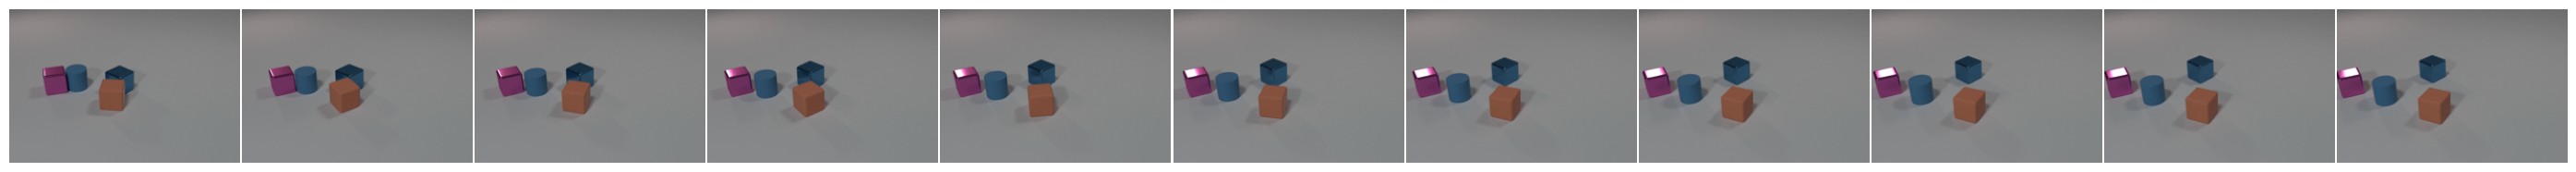

In [27]:
import numpy as np
from openstl.utils import show_video_line

# show the given frames from an example
inputs = np.load('./work_dirs/custom_exp/saved/inputs.npy')
preds = np.load('./work_dirs/custom_exp/saved/preds.npy')
trues = np.load('./work_dirs/custom_exp/saved/trues.npy')

example_idx = 0
show_video_line(trues[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

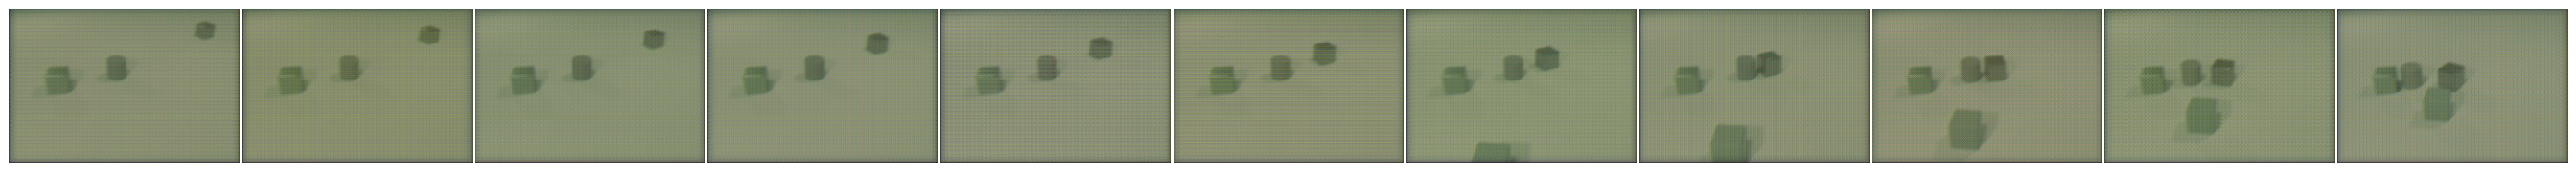

In [28]:
example_idx = 0
show_video_line(preds[example_idx], ncols=aft_seq_length, vmax=0.6, cbar=False, out_path=None, format='png', use_rgb=True)

### 4.2 Generate a GIF

/scratch/sn3250/DL/project/OpenSTL/openstl/utils/visualization.py:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 6))


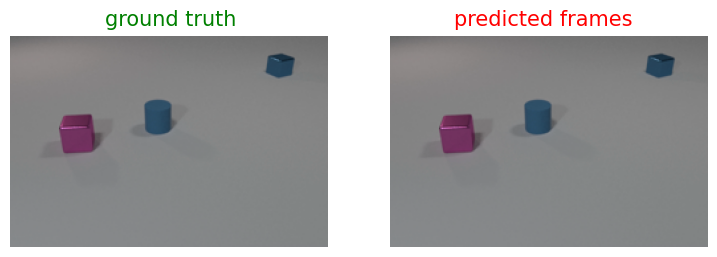

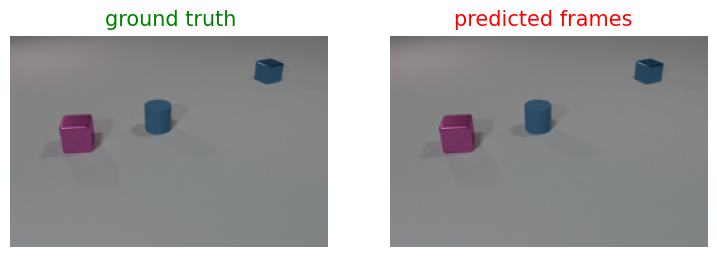

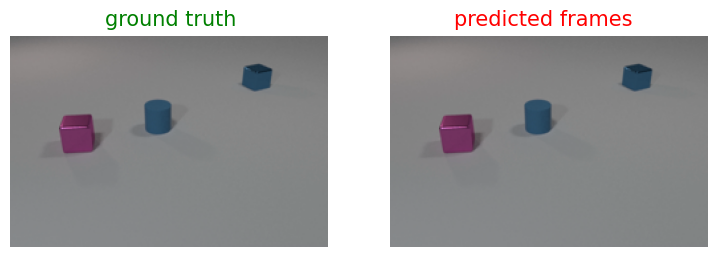

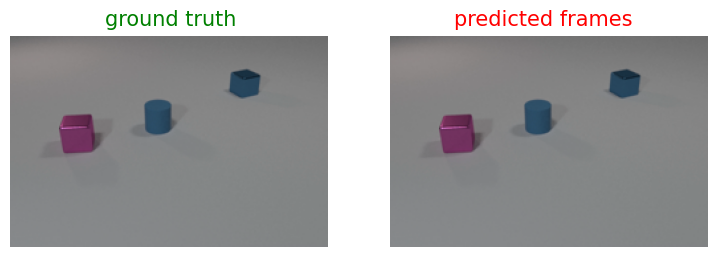

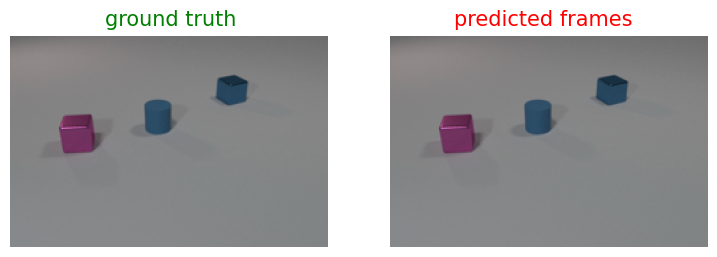

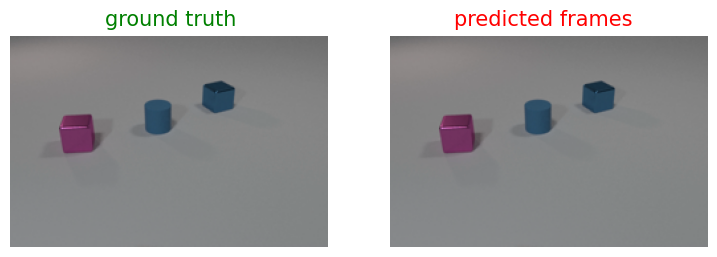

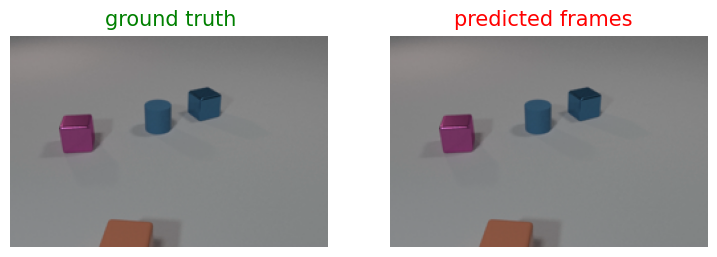

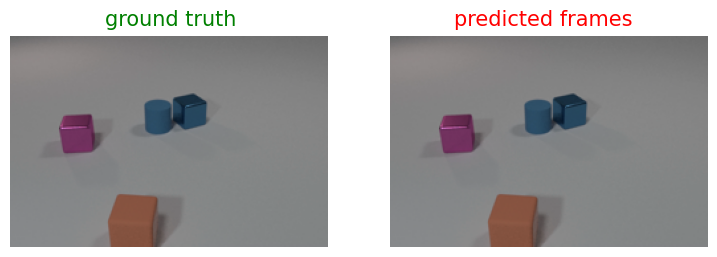

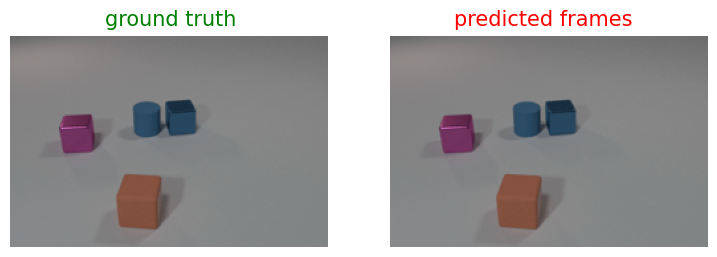

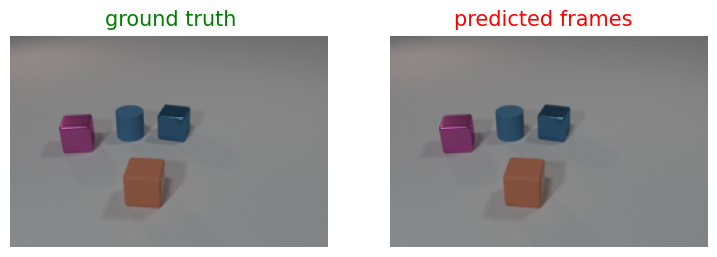

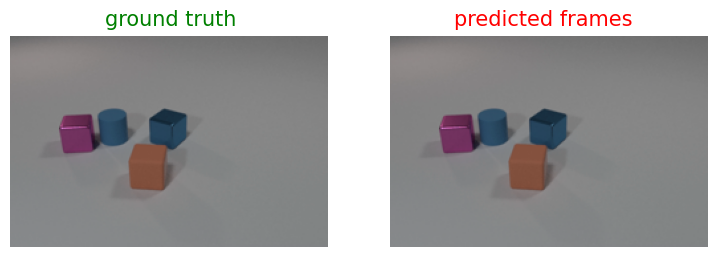

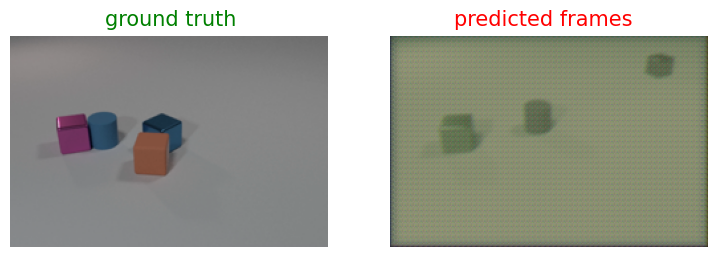

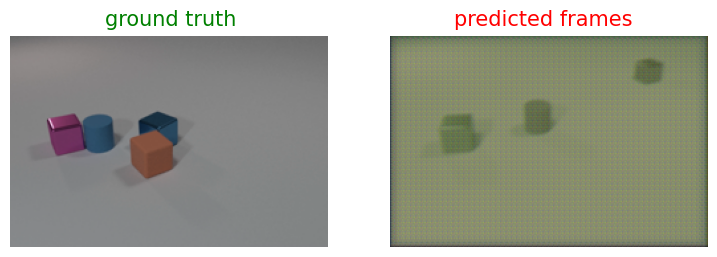

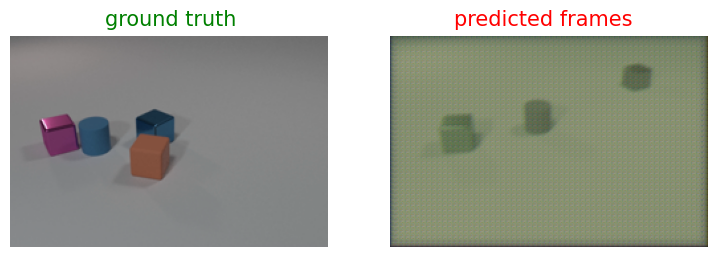

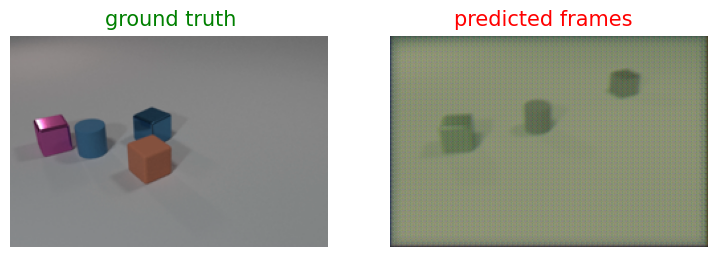

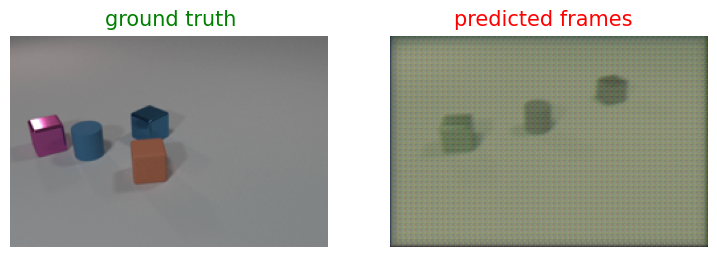

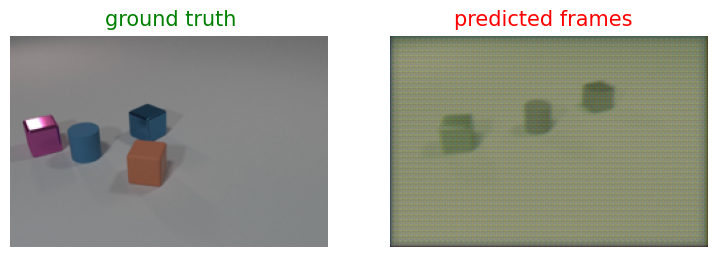

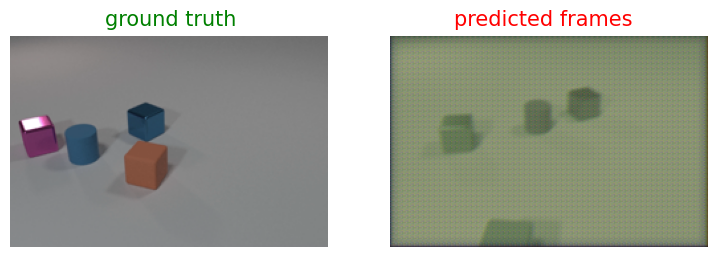

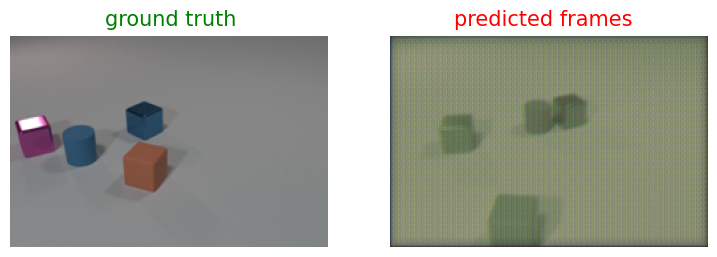

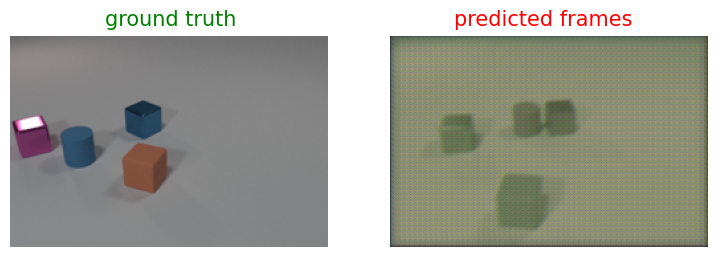

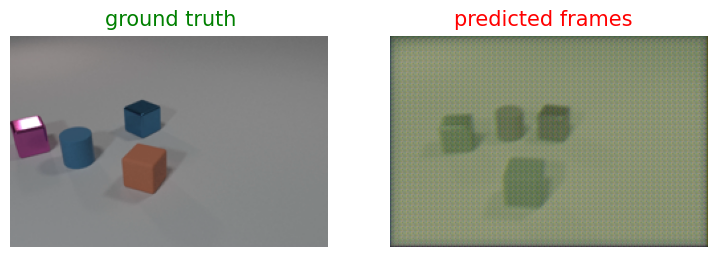

In [29]:
from openstl.utils import show_video_gif_multiple

example_idx = 0
show_video_gif_multiple(inputs[example_idx], trues[example_idx], preds[example_idx], use_rgb=True, out_path='example.gif')

## Viz single pred

In [56]:
import matplotlib.pyplot as plt

In [57]:
preds.shape

(4, 11, 3, 160, 240)

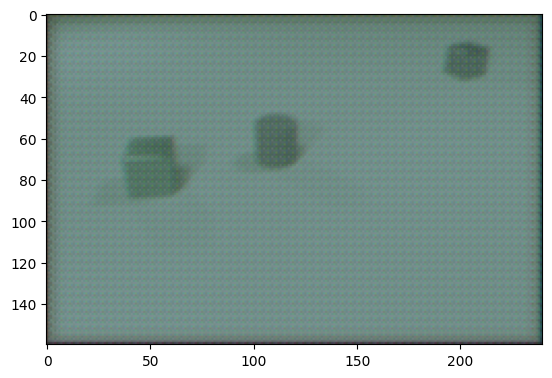

In [58]:
plt.imshow(preds[0,0].transpose(1,2,0))

In [66]:
# img_n = cv2.normalize(src=preds[0,0].transpose(1,2,0), dst=None, alpha=0, beta=255, 
#                       norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
# plt.imshow(img_n)